In [1]:
import pandas as pd
import numpy  as np

import pickle
 
from pathlib import Path


import statsmodels.api as sm

import matplotlib.pyplot as plt


import sys
sys.path.append("D:/analyze_Pearson_residuals")

from  plot_tab_utilities import *



pd.set_option('display.max_columns', 5)

In [2]:
#### user specified
data_folder = r"D:/analyze_Pearson_residuals/"

data_subfolder = "Kang_Lupus"

data_path = Path ( data_folder + data_subfolder )

In [3]:
# output plots
Ag_plot_jpg = data_subfolder + "_Figure_2.jpg"
Lg_plot_jpg = data_subfolder + "_Figure_4.jpg"  
Sg_plot_jpg = data_subfolder + "_Figure_6.jpg"


# input data
nru_dict_pkl =  "nru_dict.pkl"
scanpy_variance_pkl = "residual_variance_scanpy.pkl"
SCT_variance_pkl = "SCT_v2_residual_variance.pkl"
Ag_complementary_pkl = "Ag_complementary_samples.pkl"
Lg_complementary_pkl = "Lg_complementary_samples.pkl"
Sg_complementary_pkl = "Sg_complementary_samples.pkl"
 


# paths: output plots
Ag_plot_dsn = data_path / Ag_plot_jpg
Lg_plot_dsn = data_path / Lg_plot_jpg
Sg_plot_dsn = data_path / Sg_plot_jpg

# paths: input data
nru_dict_dsn = data_path / nru_dict_pkl
scanpy_variance_dsn = data_path / scanpy_variance_pkl
SCT_variance_dsn = data_path / SCT_variance_pkl
Ag_complementary_dsn = data_path / Ag_complementary_pkl
Lg_complementary_dsn = data_path / Lg_complementary_pkl
Sg_complementary_dsn = data_path / Sg_complementary_pkl

In [4]:
def plot_tab ( df_analy, method_symbol, method_label, plot_jpg_dsn ):

  df_analy['ratio'] = df_analy[1]/ df_analy[0]
  df_analy['abs_log_ratio'] = np.abs ( np.log10 ( df_analy['ratio'] ) ) 
 
  df_analy['rank_stat'] = df_analy['stat'].rank ( ascending=False )
  df_analy['rank_0'] = df_analy[0].rank ( ascending=False )
  df_analy['rank_1'] = df_analy[1].rank ( ascending=False )

  df_analy['group_0'] = pd.cut ( df_analy['rank_0'], bins, labels=labels )
  df_analy['group_1']   = pd.cut ( df_analy['rank_1'], bins, labels=labels )
 
  xtab_in = df_analy.rename( columns={'group_0':'S', 'group_1':'S_tilde'} )
  pti = pv_table_noprint_margins ( xtab_in, 'S', 'S_tilde' )


  rank_stat_200 = df_analy['stat'].loc [ df_analy['rank_stat'] == 200 ].max()
  print (  '\n\n genes rank_stat_200: ', rank_stat_200 )  

  arr_unreliability = df_analy['unreliability'].values
  x = np.log10 ( arr_unreliability )
  y = df_analy['abs_log_ratio'].values

  x = sm.add_constant(x)  
  result = sm.OLS(y, x).fit()
  print( '\n\n', result.summary() )

  max_unreliability = np.max ( arr_unreliability )
  max_log10_unreliability = np.log10 ( max_unreliability )  
  ypred_x_max = result.predict( [1, max_log10_unreliability] )
  ypred_x_min = result.predict( [1, 0] )
 
  fig, (ax1, ax2, ax3 )  = plt.subplots(1,3, figsize=( 8., 3. ) )

  plot_ax ( df_analy, ax1, 'A', 0, 1, 'sample S', 'sample $\~S$'  )
  
  plot_ax ( df_analy, ax2, 'B', 'stat', 'abs_log_ratio', method_label, 'abs ( log$_1$$_0$ ( ' + method_symbol + '($\~S$) / ' + method_symbol + '(S) ) )' , yscale_log=False, line_slope='none' )
  ax2.axvline ( rank_stat_200,  linewidth=1, color='red') 
  y_min2, y_max2 = ax2.get_ylim()

  plot_ax ( df_analy, ax3, 'C', 'unreliability', 'abs_log_ratio', 'unreliability ratio: ' + "$M_g$" + '/' + "$A_g$", \
  'abs ( log$_1$$_0$ ( ' + method_symbol + '($\~S$) / ' + method_symbol + '(S) ) )' , yscale_log=False, line_slope='none' )
  ax3.plot ( [ 1, max_unreliability ], [ ypred_x_min, ypred_x_max ], linewidth=1, color='red')  
  y_min3, y_max3 = ax3.get_ylim()   
 
  y_min = min ( y_min2, y_min3 )
  y_max = max ( y_max2, y_max3 )
  ax2.set_ylim ( y_min, y_max )
  ax3.set_ylim ( y_min, y_max ) 
    
    
  plt.subplots_adjust( wspace=0.3, bottom=0.2 )
  plt.savefig(  plot_jpg_dsn, transparent=True, dpi=300 )  
    
  return pti

In [5]:
pctl_list = [.01,.05, .10, .25, .5, .75, .90, .95, .99 ]


bins = [ 0, 20, 50, 100, 200, 500, 2000, 1e6]
labels = ['1-20', '21-50', '51-100', '101-200', '201-500','501-2000', '2001+']

In [6]:
f = open( nru_dict_dsn, 'rb' )    
nru_dict = pickle.load(f)           
f.close()       


df_unreliability = nru_dict['df_gene_stats'] [['A_g', 'M_g']]
df_unreliability = df_unreliability.assign( unreliability = df_unreliability['M_g'] / df_unreliability['A_g'] )
print ( ' df_unreliability:  ' )
print ( '\n', df_unreliability )
print ( '\n\n df_unreliability.describe' )
print ( df_unreliability[['unreliability']].describe ( percentiles=pctl_list ) )


df_A_g = nru_dict['df_gene_stats'] [['A_g']].rename( columns={'A_g':'stat'} )
print ( '\n\n df_A_g:  ' )
print ( '\n', df_A_g )

 
df_L_g = pd.read_pickle ( scanpy_variance_dsn )[['CLIPPED']].rename( columns={'CLIPPED':'stat'} )
print ( '\n\n df_L_g:  ' )
print ( '\n', df_L_g )


df_S_g = pd.read_pickle ( SCT_variance_dsn ).rename( columns={'residual_variance':'stat'} )
print ( '\n\n df_S_g:  ' )
print ( '\n', df_S_g )

 df_unreliability:  

                         A_g         M_g  unreliability
ENSG00000244734  583.983476  618.223412       1.058632
ENSG00000188536  170.301545  187.010513       1.098114
ENSG00000167996   94.267171   95.555335       1.013665
ENSG00000206172   93.234056  105.145843       1.127762
ENSG00000087086   82.854512   83.811940       1.011556
...                     ...         ...            ...
ENSG00000136492    0.612331    0.709007       1.157882
ENSG00000253593    0.612331    0.722536       1.179976
ENSG00000172379    0.612331    0.717869       1.172354
ENSG00000226004    0.612331    0.690656       1.127913
ENSG00000123643    0.612331    0.743041       1.213463

[10619 rows x 3 columns]


 df_unreliability.describe
       unreliability
count   10619.000000
mean        1.157328
std         0.628142
min         1.000000
1%          1.022221
5%          1.037558
10%         1.047490
25%         1.067255
50%         1.103320
75%         1.162001
90%         1.261892
95%       


  A_g


 df_complementary_stats_Ag

                           0           1
ENSG00000244734  588.145207  501.531965
ENSG00000188536  169.392362  153.041075
ENSG00000167996   92.837921   93.239858
ENSG00000206172   91.970705   90.978825
ENSG00000087086   81.418673   80.393600
...                     ...         ...
ENSG00000162433    0.636398    0.720220
ENSG00000182197    0.636398    0.675587
ENSG00000029153    0.636398    0.623028
ENSG00000160883    0.636398    0.700949
ENSG00000158186    0.636398    0.623028

[9091 rows x 2 columns]


 genes rank_stat_200:  2.4078712652067837


                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     434.6
Date:                Tue, 11 Jul 2023   Prob (F-statistic):           2.55e-94
Time:          

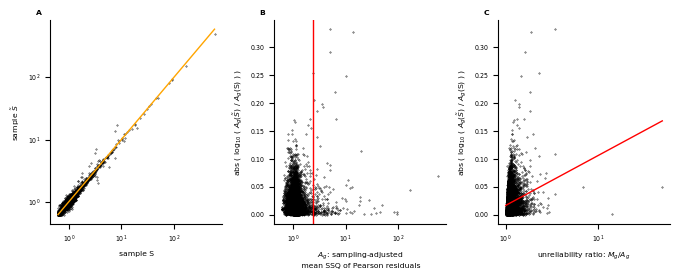

In [7]:
print ( '\n  A_g' )  
df_complementary_stats_Ag = pd.read_pickle ( Ag_complementary_dsn )  
print ( '\n\n df_complementary_stats_Ag' )
print ( '\n', df_complementary_stats_Ag )  

df_A_g_UR = pd.concat ( [ df_A_g[['stat']], df_unreliability[['unreliability']] ], axis=1 )
df_stats_Ag = df_A_g_UR.merge ( df_complementary_stats_Ag, how='inner', left_index=True, right_index=True )
pti = plot_tab ( df_stats_Ag, "$A_g$", '$A_g$: sampling-adjusted \n mean SSQ of Pearson residuals',  Ag_plot_dsn ) 
print ( '\n\n Table 3' )
pd.set_option('display.max_columns', 8)
print ( '\n', pti )  
pd.set_option('display.max_columns', 5)


  L_g


 df_complementary_stats_Lg

                          0          1
ENSEMBL_ID                           
ENSG00000087086  50.711936  51.099089
ENSG00000167996  42.481003  42.322134
ENSG00000169245  40.903462  40.700295
ENSG00000187608  38.979586  38.098613
ENSG00000244734  37.104743  46.446606
...                    ...        ...
ENSG00000179331   0.679744   0.886626
ENSG00000079215   0.677357   0.889302
ENSG00000116991   0.665157   0.758688
ENSG00000241399   0.650771   0.716066
ENSG00000113494   0.636110   0.653710

[9091 rows x 2 columns]


 genes rank_stat_200:  2.627377852048473


                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                 1.082e+04
Date:                Tue, 11 Jul 2023   Prob (F-statistic):               0.00
Ti

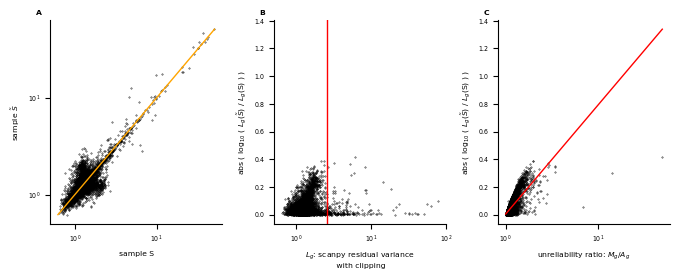

In [8]:
print ( '\n  L_g' )  
df_complementary_stats_Lg = pd.read_pickle ( Lg_complementary_dsn )  
print ( '\n\n df_complementary_stats_Lg' )
print ( '\n', df_complementary_stats_Lg )  

df_L_g_UR = pd.concat ( [ df_L_g[['stat']], df_unreliability[['unreliability']] ], axis=1 )
df_stats_Lg = df_L_g_UR.merge ( df_complementary_stats_Lg, how='inner', left_index=True, right_index=True )
pti = plot_tab ( df_stats_Lg,  "$L_g$", '$L_g$: scanpy residual variance \n with clipping', Lg_plot_dsn ) 
print ( '\n\n Table 5' )
pd.set_option('display.max_columns', 8)
print ( '\n', pti )  
pd.set_option('display.max_columns', 5)


  S_g


 df_complementary_stats_Sg

                         0         1
gene_vector                        
ENSG00000000419  1.119078  1.028459
ENSG00000000457  0.305840  0.256165
ENSG00000000938  0.828076  0.835764
ENSG00000001036  0.412737  0.410825
ENSG00000001084  0.258487  0.279365
...                   ...       ...
ENSG00000273272  0.528022  0.467131
ENSG00000273319  0.166517  0.155134
ENSG00000273341  0.546378  0.570863
ENSG00000273344  0.572827  0.846323
ENSG00000273445  1.019414  1.062243

[9091 rows x 2 columns]


 genes rank_stat_200:  1.784637768737519


                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.429
Method:                 Least Squares   F-statistic:                     6832.
Date:                Tue, 11 Jul 2023   Prob (F-statistic):               0.00
Time:                       

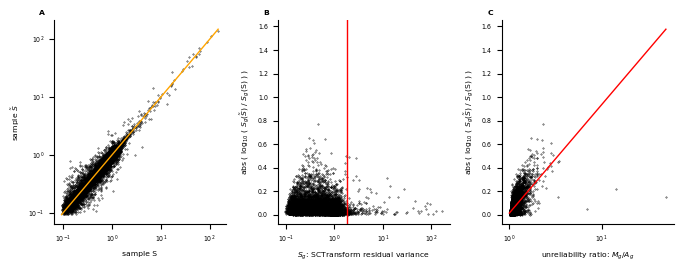

In [9]:
print ( '\n  S_g' )  
df_complementary_stats_Sg = pd.read_pickle ( Sg_complementary_dsn ).set_index ( ['gene_vector'] ).rename( columns={'0':0, '1':1 } )
print ( '\n\n df_complementary_stats_Sg' )
print ( '\n', df_complementary_stats_Sg ) 
 
df_S_g_UR = pd.concat ( [ df_S_g[['stat']], df_unreliability[['unreliability']] ], axis=1 )
df_stats_Sg = df_S_g_UR.merge ( df_complementary_stats_Sg, how='inner', left_index=True, right_index=True )
pti = plot_tab ( df_stats_Sg,  "$S_g$" , '$S_g$: SCTransform residual variance', Sg_plot_dsn ) 
print ( '\n\n Table 7' )
pd.set_option('display.max_columns', 8)
print ( '\n', pti )  
pd.set_option('display.max_columns', 5)